In [1]:
import os
import pandas as pd

def load_parquet_files(directory):
    """
    Loads all Parquet files from a specified directory into a dictionary of DataFrames.
    """
    dataframes = {}
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return dataframes

    for filename in os.listdir(directory):
        if filename.endswith('.parquet'):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_parquet(file_path)
                dataframes[os.path.splitext(filename)[0]] = df
                print(f"Loaded {filename}")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")
    
    return dataframes

# Standardized data prior to running analysis
stndz_dir = os.path.join(os.getcwd(), '..', 'data', 'processed')

# Load Parquet files into dataframes dictionary
dataframes = load_parquet_files(stndz_dir)

Loaded demographics.parquet
Loaded facilities.parquet
Loaded claims.parquet


In [2]:
# Merge claims and demographics

claims = dataframes['claims']
demographics = dataframes['demographics']

# Join
joined_df = pd.merge(claims, demographics, left_on='clinician_npi', right_on='npi')

# Filter
specialties = ['INTERNAL MEDICINE', 'UROLOGY', 'ANESTHESIOLOGY']
filtered_df = joined_df[joined_df['specialty'].isin(specialties)] # no subspecialties in above categories


In [5]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Convert year and quarter to a single datetime column
filtered_df['date'] = pd.to_datetime(joined_df['year'].astype(str) + 'Q' + joined_df['quarter'].astype(str))

# Aggregate data by date for each specialty
agg_df = filtered_df.groupby(['specialty', 'date'])['total_claims'].sum().reset_index()

# Define p, d, and q ranges to try
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

# Store best models
best_models = {}

# Perform grid search
for specialty in specialties:
    best_aic = float('inf')
    best_pdq = None
    best_model = None
    
    # Filter data for the current specialty
    specialty_data = agg_df[agg_df['specialty'] == specialty].set_index('date')['total_claims']
    
    # Grid search
    for pdq in pdq_combinations:
        try:
            model = ARIMA(specialty_data, order=pdq)
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = pdq
                best_model = results
        except Exception as e:
            continue
    
    best_models[specialty] = (best_pdq, best_aic, best_model)

# Display the best model for each specialty
for specialty, (pdq, aic, model) in best_models.items():
    print(f"Best ARIMA Model for {specialty}: PDQ={pdq}, AIC={aic}")


Best ARIMA Model for INTERNAL MEDICINE: PDQ=(0, 2, 0), AIC=140.29360868916729
Best ARIMA Model for UROLOGY: PDQ=(0, 2, 0), AIC=109.97480941659073
Best ARIMA Model for ANESTHESIOLOGY: PDQ=(1, 2, 0), AIC=112.69910507548141


INTERNAL MEDICINE - MSE: 486194852.25, RMSE: 22049.8265809507, MAE: 19074.75, MAPE: 4.146396074983129%
ANESTHESIOLOGY - MSE: 7065117.5, RMSE: 2658.0288749372157, MAE: 2228.5, MAPE: 5.671670927888371%
UROLOGY - MSE: 2690553.25, RMSE: 1640.290599253681, MAE: 1373.25, MAPE: 4.132512237539167%
Forecast for INTERNAL MEDICINE in 2023: 2022-01-01    483600.0
2022-04-01    484840.0
2022-07-01    486080.0
2022-10-01    487320.0
Freq: QS-OCT, Name: predicted_mean, dtype: float64


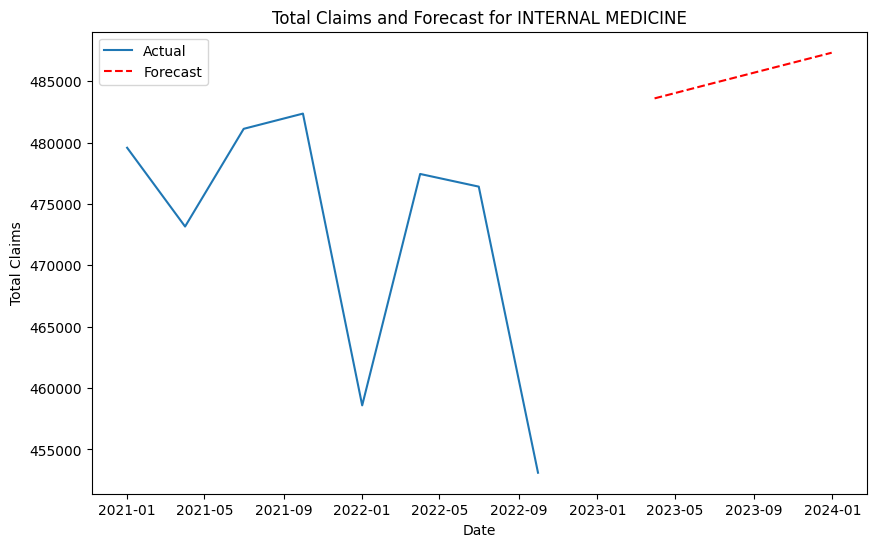

Forecast for ANESTHESIOLOGY in 2023: 2022-01-01    36136.0
2022-04-01    36136.0
2022-07-01    36136.0
2022-10-01    36136.0
Freq: QS-OCT, Name: predicted_mean, dtype: float64


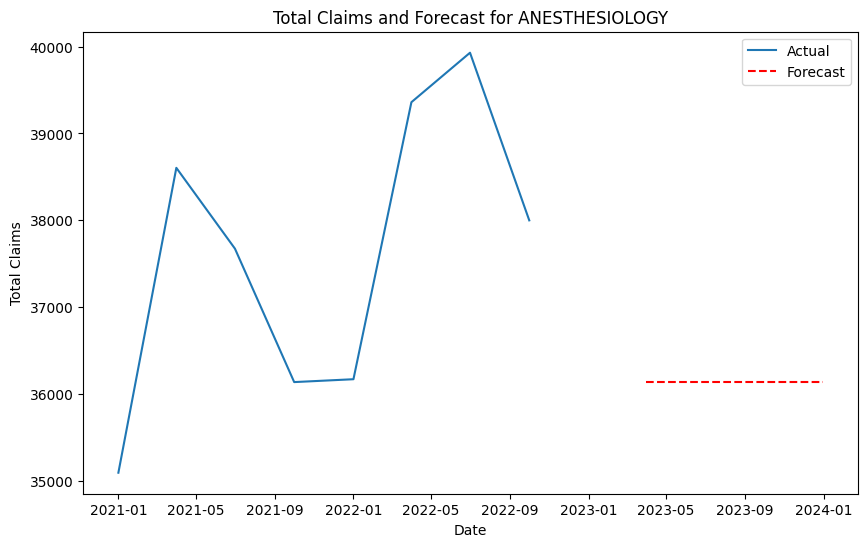

Forecast for UROLOGY in 2023: 2022-01-01    31326.0
2022-04-01    31326.0
2022-07-01    31326.0
2022-10-01    31326.0
Freq: QS-OCT, Name: predicted_mean, dtype: float64


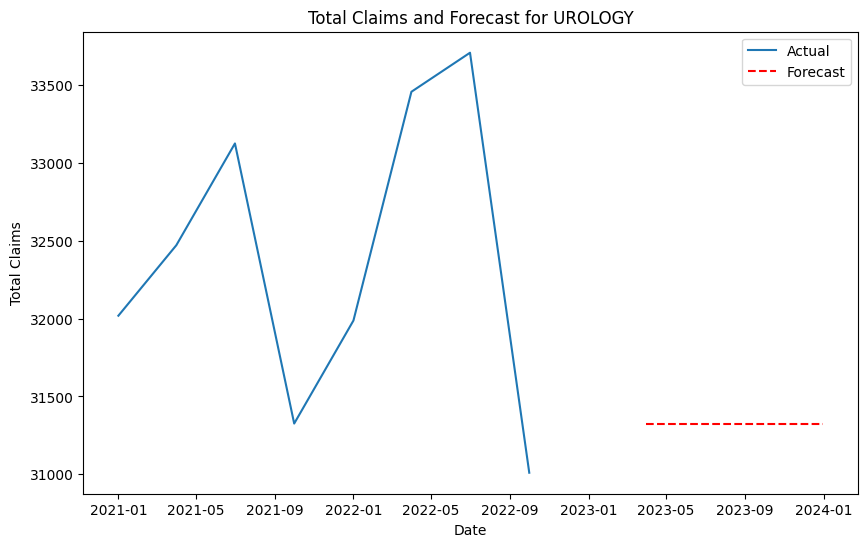

In [10]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Convert year and quarter to a single datetime column
filtered_df['date'] = pd.to_datetime(filtered_df['year'].astype(str) + 'Q' + filtered_df['quarter'].astype(str))

# Create training and testing
train_test_split = {}
test_periods = 4

for specialty in filtered_df['specialty'].unique():
    df_specialty = filtered_df[filtered_df['specialty'] == specialty]
    df_specialty_agg = df_specialty.groupby('date')['total_claims'].sum()

    if len(df_specialty_agg) > test_periods:
        train_data = df_specialty_agg.iloc[:-test_periods]
        test_data = df_specialty_agg.iloc[-test_periods:]
        train_test_split[specialty] = {'train': train_data, 'test': test_data}
    else:
        print(f"Not enough data to split for specialty: {specialty}. Skipping.")

# Custom ARIMA parameters for each specialty
custom_params = {
    'INTERNAL MEDICINE': (0, 2, 0),
    'UROLOGY': (0, 1, 0),
    'ANESTHESIOLOGY': (0, 1, 0)
}

# ARIMA models and forecasts 
arima_models = {}
accuracy_metrics = {}
forecasts = {}

for specialty, data in train_test_split.items():
    train_data = data['train']
    test_data = data['test']

    # Get custom parameters if available, else use default parameters
    p, d, q = custom_params.get(specialty, (0, 1, 0))

    try:
        arima_model = ARIMA(train_data, order=(p, d, q))
        arima_result = arima_model.fit()
        arima_models[specialty] = arima_result

        # Forecasting the test data period
        forecast = arima_result.forecast(steps=len(test_data))
        forecasts[specialty] = forecast

        # Calculate accuracy metrics
        mse = mean_squared_error(test_data, forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_data, forecast)
        mape = np.mean(np.abs(test_data - forecast) / test_data) * 100

        accuracy_metrics[specialty] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
    except Exception as e:
        print(f"Failed to fit and forecast ARIMA model for {specialty}: {e}")

# Display the accuracy metrics for each specialty
for specialty, metrics in accuracy_metrics.items():
    print(f"{specialty} - MSE: {metrics['MSE']}, RMSE: {metrics['RMSE']}, MAE: {metrics['MAE']}, MAPE: {metrics['MAPE']}%")

# Results and Plot
for specialty, forecast in forecasts.items():
    print(f"Forecast for {specialty} in 2023: {forecast}")
    specialty_df = filtered_df[filtered_df['specialty'] == specialty].groupby('date')['total_claims'].sum()
    plt.figure(figsize=(10, 6))
    plt.plot(specialty_df.index, specialty_df, label='Actual')
    future_dates = pd.date_range(start=specialty_df.index[-1], periods=len(forecast)+1, freq='Q')[1:]
    plt.plot(future_dates, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f'Total Claims and Forecast for {specialty}')
    plt.xlabel('Date')
    plt.ylabel('Total Claims')
    plt.legend()
    plt.show()
